In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
%matplotlib inline


#Configurable parameters for pure pursuit
+ How fast do you want the robot to move? It is fixed at $v_{max}$ in this exercise
+ When can we declare the goal has been reached?
+ What is the lookahead distance? Determines the next position on the reference path that we want the vehicle to catch up to

In [ ]:
vmax = 0.75
goal_threshold = 0.05
lookahead = 3.0

In [ ]:
#You know what to do!
def simulate_unicycle(pose, v,w, dt=0.1):
    x, y, t = pose
    return x + v*np.cos(t)*dt, y + v*np.sin(t)*dt, t+w*dt

In [79]:
class PurePursuitTracker(object):
    def __init__(self, x, y, v, lookahead = 3.0):
        """
        Tracks the path defined by x, y at velocity v
        x and y must be numpy arrays
        v and lookahead are floats
        """
        self.length = len(x)
        print(self.length)
        self.ref_idx = 0 #index on the path that tracker is to track
        self.lookahead = lookahead
        self.x, self.y = x, y
        self.v, self.w = v, 0

    def update(self, xc, yc, theta):
        """
        Input: xc, yc, theta - current pose of the robot
        Update v, w based on current pose
        Returns True if trajectory is over.
        """
        
        #Calculate ref_x, ref_y using current ref_idx
        #Check if we reached the end of path, then return TRUE
        #Two conditions must satisfy
        #1. ref_idx exceeds length of traj
        #2. ref_x, ref_y must be within goal_threshold
        # Write your code to check end condition

        ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]
        goal_x, goal_y = self.x[-1], self.y[-1]
        if self.ref_idx >= (self.length)-1 and np.linalg.norm([ref_x-goal_x, ref_y-goal_y]) < goal_threshold:
          return True
        
        #End of path has not been reached
        #update ref_idx using np.hypot([ref_x-xc, ref_y-yc]) < lookahead
        while np.hypot(ref_x-xc, ref_y-yc) < self.lookahead:
          self.ref_idx+=1
          if self.ref_idx!=self.length:
            ref_x, ref_y = self.x[self.ref_idx], self.y[self.ref_idx]
          else:
            break
          
        self.ref_idx=self.ref_idx-1
        
            

        #Find the anchor point
        # this is the line we drew between (0, 0) and (x, y)
        anchor = np.asarray([ref_x - xc, ref_y - yc])
        #Remember right now this is drawn from current robot pose
        #we have to rotate the anchor to (0, 0, pi/2)
        #code is given below for this
        theta = np.pi/2 - theta
        rot = np.asarray([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        anchor = np.dot(rot, anchor)
        
        L = (anchor[0] ** 2 + anchor[1] **2) # dist to reference path
        X = anchor[0] #cross-track error
        #from the derivation in notes, plug in the formula for omega
        self.w = -(2*self.v*X)/L
        
        return False

## Visualize given trajectory

In [107]:
x_path = np.arange(0, 50, 0.5)
y_path = [np.sin(idx / 5.0) * idx / 2.0 for idx in x]

#write code here


## Run the tracker simulation

1. Instantiate the tracker class
2. Initialize some starting pose
3. Simulate robot motion 1 step at a time - get $v$, $\omega$ from tracker, predict new pose using $v$, $\omega$, current pose in simulate_unicycle()
4. Stop simulation if tracker declares that end-of-path is reached
5. Record all parameters

In [149]:
#write code to instantiate the tracker class
tracker = PurePursuitTracker(x,y,vmax) 
pose = -1, 0, np.pi/2 #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting
traj =[]
while True:
    #write the usual code to obtain successive poses
    pose = simulate_unicycle(pose, tracker.v, tracker.w)
    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx])


100
ARRIVED!!


1347

1347


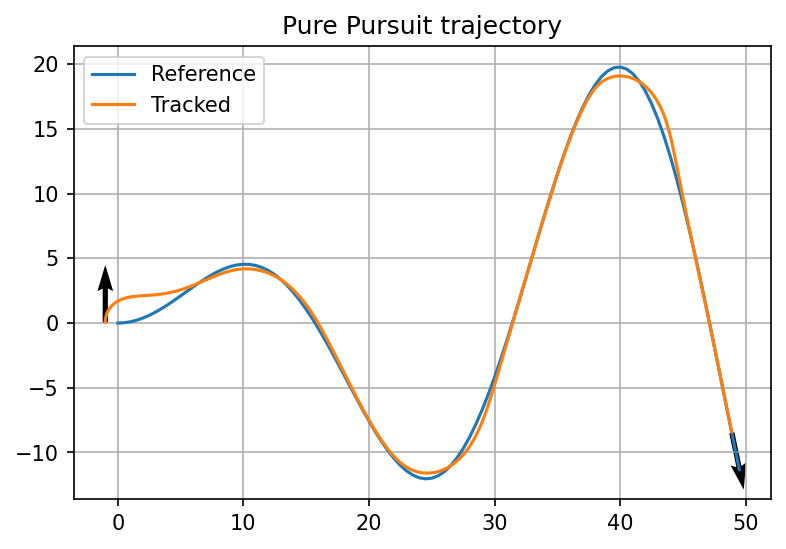

In [109]:
xs,ys,ts,ws,ids = zip(*traj)
print(len(xs))
plt.figure()
plt.plot(x,y,label='Reference')
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.plot(xs,ys,label='Tracked')
x0,y0,t0 = pose
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.title('Pure Pursuit trajectory')
plt.legend()
plt.grid()

# Visualize curvature

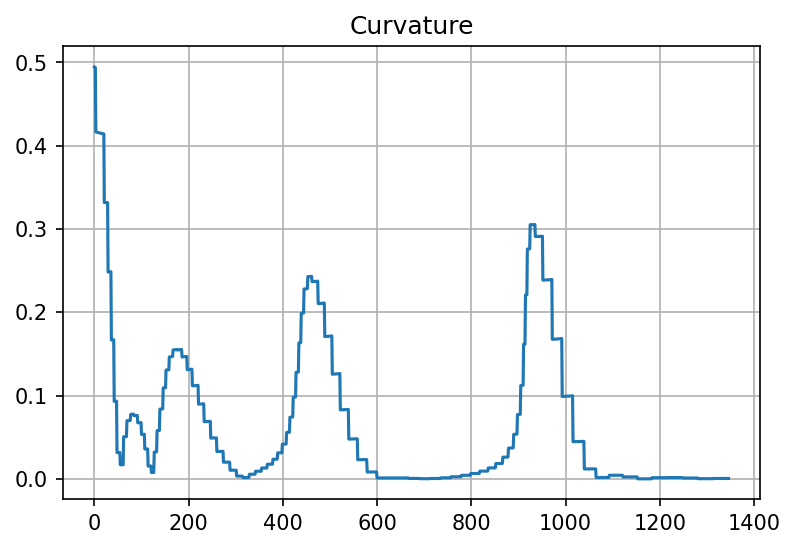

In [110]:
plt.figure()
plt.title('Curvature')
plt.plot(np.abs(ws))
plt.grid()


## Animate

Make a video to plot the current pose of the robot and reference pose it is trying to track. You can use funcAnimation in matplotlib

In [156]:
plt.rcParams["animation.html"]="jshtml"
plt.rcParams['figure.dpi']=150
plt.ioff()
fig,ax=plt.subplots()
n=0;

def animate(i):
  global n
  plt.cla()
  plt.xlim(-10,60)
  plt.ylim(-30,30)
  plt.grid()
  plt.plot(x_path,y_path,'b',label='reference')
  plt.plot(xs[0:i+n*i],ys[0:i+n*i],'r',label='tracked')
  if i+n*i < len(ids):
    index=ids[i+n*i]
    plt.scatter(x_path[index],y_path[index],color='yellow',s=20)
  plt.legend() 
 # x,y=x_path[index],y_path[index]
  #plt.plot(x,y)
  n+=1

animation.FuncAnimation(fig,animate,frames=50)

Output hidden; open in https://colab.research.google.com to view.

## Effect of noise in simulations

What happens if you add a bit of Gaussian noise to the simulate_unicycle() output? Is the tracker still robust?

The noise signifies that $v$, $\omega$ commands did not get realized exactly


In [161]:
#code to instantiate the tracker class with noise
tracker = PurePursuitTracker(x,y,vmax) 
pose = [-1, 0, np.pi/2] #arbitrary initial pose
x0,y0,t0 = pose # record it for plotting
traj =[]
while True:
    #write the usual code to obtain successive poses
    pose = list(simulate_unicycle(pose, tracker.v, tracker.w))
    noise=np.random.normal(0,0.05)
    pose[0]=pose[0]+noise
    pose[1]=pose[1]+noise
    pose[2]=pose[2]+noise
    if tracker.update(*pose):
        print("ARRIVED!!")    
        break
    traj.append([*pose, tracker.w, tracker.ref_idx])


100
ARRIVED!!


1388


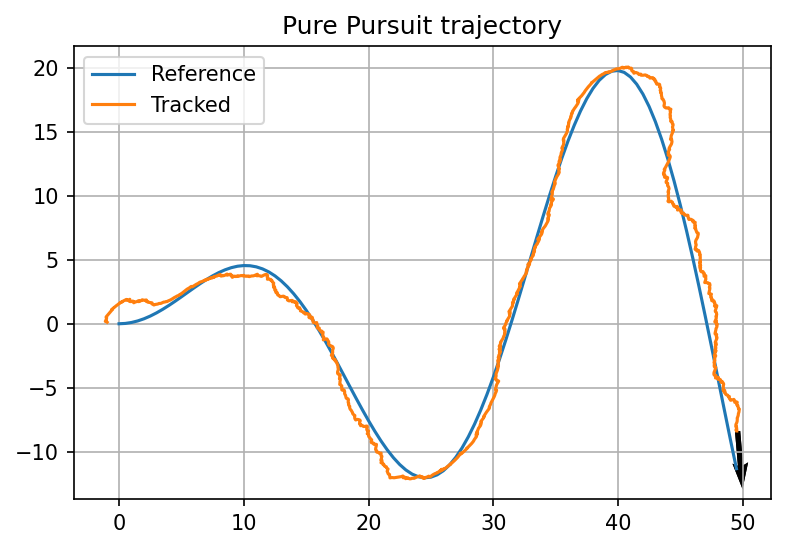

In [165]:
#Visualisation of the tracker witn noisy robot
xs,ys,ts,ws,ids = zip(*traj)
print(len(xs))
plt.figure()
plt.plot(x,y,label='Reference')
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.plot(xs,ys,label='Tracked')
x0,y0,t0 = pose
plt.quiver(x0,y0, np.cos(t0), np.sin(t0),scale=12)
plt.title('Pure Pursuit trajectory')
plt.legend()
plt.grid()

In [168]:
#animation of tracker with noisy robot
plt.rcParams["animation.html"]="jshtml"
plt.rcParams['figure.dpi']=150
plt.ioff()
fig,ax=plt.subplots()
n=0;

def animate(i):
  global n
  plt.cla()
  plt.xlim(-10,60)
  plt.ylim(-30,30)
  plt.grid()
  plt.plot(x_path,y_path,'b',label='reference')
  plt.plot(xs[0:i+n*i],ys[0:i+n*i],'r',label='tracked')
  if i+n*i < len(ids):
    index=ids[i+n*i]
    plt.scatter(x_path[index],y_path[index],color='yellow',s=20)
  plt.legend() 
 # x,y=x_path[index],y_path[index]
  #plt.plot(x,y)
  n+=1

animation.FuncAnimation(fig,animate,frames=50)

Output hidden; open in https://colab.research.google.com to view.